# Evaluate commuter data over time
The code below takes labbeled data, trains a model with a growing amount of training.
Since this is done itaratively and compared to predictions towards a test set an estimation can be made over how fast the model converges.


In [1]:
#Setup
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai
from fastai.vision import *
PATH="data/"
dep_var = 'journey'
cat_names = ["detectedActivity","weekday"]
cont_names =["geoHash","minuteOfDay"]
procs = [FillMissing, Categorify, Normalize]
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn

def predict_journeys(learner,dataset):  
    "Return"
    result = 0
    accuracy = 0
    for x in range(0,dataset.shape[0]):
        correct = dataset.iloc[x].journey  #remove journey
        predicted = learner.predict(dataset.iloc[x]);
        if (str(correct)==str(predicted[0])):
            result=result+1
    accuracy=result/dataset.shape[0]
    return(accuracy)
    
def predict_journey(detectedActivity,geoHash,minuteOfday,weekday):
    data = np.array([['','detectedActivity','geoHash','minuteOfDay','weekday'],
                ["row1",detectedActivity,geoHash,minuteOfday,weekday]])            
    dr=pd.DataFrame(data=data[1:,1:],
                    index=data[1:,0],
                    columns=data[0,1:]).astype(np.int64)
    predicted = learner.predict(dr.iloc[0])
    return(predicted[0],str(round(predicted[2].max().item(),2)))

def evaluate_learner(rows_per_training:int,trainingset,testset,length_teachingSet=0): #Minimal start for any training can bne used for offset
    result = []
    if length_teachingSet>0: #do teaching and add thus add startdata for day 0
        start_point = length_teachingSet
    else: #no teachin set exists add row for day 0
        result.append([0,0,0])
        start_point = rows_per_training
    for rows in range(start_point,len(trainingset),rows_per_training):
        df=trainingset[0:rows]
        df=make_shure_we_got_enough_rows(df)
        valid_idx= list(np.random.randint(0,len(df),int(len(df)*0.1))) #If we want 10% random instead of same 10 rows...
        #valid_idx = range(int(len(df)*0.9), len(df))  #Here always last 10% is used for validation 
        data = (TabularList.from_df(df, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch())
        learner=tabular_learner(data, layers=[200,100], metrics=accuracy)
        learner.fit_one_cycle(10)
        #learner.fit(5, 1e-2)
        sizeR = len(learner.recorder.metrics)
        resultTest = predict_journeys(learner,testset)
        result.append([rows,learner.recorder.metrics[sizeR-1][0].item(),resultTest])
    return (result)

def make_shure_we_got_enough_rows(dataset,minrows=500):
    "If the dataset has fewer rows that minrows, whole dataset copies will be added at the end until at least minrows exists"
    newset = pd.DataFrame()
    while newset.shape[0]<minrows:
        newset = pd.concat([newset,dataset])
    return(newset)

def save_results(filename,result):
    a = np.asarray(result)
    np.savetxt("saved/"+filename,a,delimiter=',',fmt="%10.2f")

### Training iteratively every day
Here we simulate training every day from the start. The result is evaluated towards a testset created from the training set.

In [12]:
%%capture
#Training without teaching set
trainingset = pd.read_csv("data/"+user+"_train_valid.csv")
#Take 14 days
trainingset=trainingset[0:int(trainingset.shape[0]/24)]
testset = pd.read_csv("data/"+user+"_test.csv")
size=trainingset.shape[0]
rows_per_training = int(size/14) # will result in about one training per day
print(rows_per_training)
print(len(trainingset))
resultTrain = evaluate_learner(rows_per_training,trainingset,testset)
save_results("Iterative_"+user+".csv",resultTrain)

### Training with initial teachingset followed by iterative training every day
Here we add a idealised teaching set in the beginning of our dataset. Then we start training from day 0 with all data in the teachingset.

In [16]:
%%capture
#Training with teaching set 
trainingset = pd.read_csv("data/"+user+"_train_valid.csv")
#Take first two weeks
trainingset=trainingset[0:int(trainingset.shape[0]/24)]
size=trainingset.shape[0]
rows_per_training = int(size/14) # will result in about one training per day
teachingset = pd.read_csv("data/"+user+"_teaching_set.csv")
trainingset = pd.concat([teachingset,trainingset])
testset = pd.read_csv("data/"+user+"_test.csv")
resultTeach = evaluate_learner(rows_per_training,trainingset,testset,len(teachingset))
save_results("TeachingIterative_"+user+".csv",resultTeach)

range(0, 15)


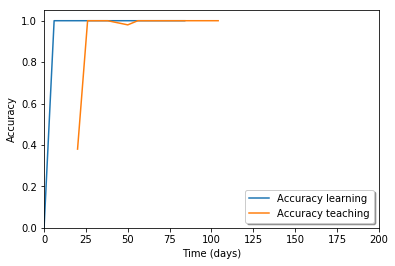

In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
learning = pd.read_csv("saved/Iterative_"+user+".csv",header=None).values
learningsize = learning.shape[0]
teaching = pd.read_csv("saved/TeachingIterative_"+user+".csv",header=None).values
teachingsize = teaching.shape[0]
rows_per_day= int(learning[3,0]-learning[2,0])
##MT
# result = np.array(resultTeach)
# size = trainingset2.shape[0]
# teachingsize = teachingset.shape[0]
#ML
#result = np.array(resultTrain)
#size = trainingset.shape[0]
#teachingsize=0

fig, ax = plt.subplots()
ax.plot(learning[:,0],learning[:,1],label='Accuracy learning')
ax.plot(teaching[:,0],teaching[:,2],label='Accuracy teaching')
plt.xlabel('Time (days)')
plt.ylabel('Accuracy')
ax.axis([0,200,0.0,1.05])
#ax.axis([0,200,0.0,1.05])
#print(size)
#print(rows_per_training)
#ax.set_xticks(np.arange(0, learningsize, 1))
xs = range(0,learningsize,1)
print(xs)
def format_fn(tick_val, tick_pos):
    if int(tick_val) in xs:
        print(tick_pos)
        return int(tick_val/rows_per_day)
    else:
         return ''
#ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

In [4]:
without_MT = result.copy()
print(without_MT)


[[ 80.         1.         0.647303]
 [ 86.         0.875      0.79668 ]
 [ 92.         0.888889   0.576763]
 [ 98.         1.         0.954357]
 [104.         0.9        0.672199]
 [110.         0.909091   0.917012]
 [116.         0.818182   0.917012]
 [122.         1.         0.979253]
 [128.         1.         0.917012]
 [134.         0.769231   0.917012]
 [140.         0.785714   0.817427]
 [146.         1.         1.      ]
 [152.         1.         1.      ]
 [158.         1.         1.      ]
 [164.         1.         1.      ]]


### Teaching
If an idealised teaching set is created that contains all combinations of categorical columns (activity and weekday) combined with a time placed in the middle of the timespan for the scenario and location at the departure station.

In [9]:
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filename = user+"_teaching_set.csv"
teachingSet = pd.read_csv("data/"+filename)
teachingSet=make_shure_we_got_enough_rows(teachingSet)
valid_idx= list(np.random.randint(0,len(teachingSet),int(len(teachingSet)*0.1))) #If we want 10% random instead of same 10 rows...
#valid_idx = range(int(len(teachingSet)*0.9), len(teachingSet))  #Here always last 10% is used for validation 
data = (TabularList.from_df(teachingSet, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
    .split_by_idx(valid_idx)
    .label_from_df(cols=dep_var)
    .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy)
learner.fit_one_cycle(40)

epoch,train_loss,valid_loss,accuracy
1,1.414923,1.392807,0.520000
2,1.254376,1.378730,0.240000
3,1.085656,1.345136,0.520000
4,0.934156,1.253220,0.520000
5,0.800818,1.075695,0.560000
6,0.681105,0.862882,0.560000
7,0.579151,0.677834,0.560000
8,0.491660,0.499605,1.000000
9,0.416812,0.299074,1.000000
10,0.354177,0.144312,1.000000


If we avaluate this on the test set

In [10]:
#%%capture
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filenameTest = user+"_test.csv"
datasetTest = pd.read_csv("data/"+filenameTest)
accuracyTest = predict_journeys(learner,datasetTest)

Print result

In [11]:
print(accuracyTest)

0.5518672199170125


In [24]:
#prediction,accuracy = predict_journey(3,1243184839,603,6) #8107980000 "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" Andrea
prediction,accuracy = predict_journey(3,1242202139,806,6) #8033880159 "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
#prediction,accuracy = predict_journey(3,1242479279,527,5) #8121680000 "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
print("Predicted journey from: "+str(prediction)[0:5]+" to " +str(prediction)[5:10]+ " with accuracy "+str(accuracy));

Predicted journey from: 80338 to 80159 with accuracy 0.91


Predict and view some rows

### Misc

### Training on parts of data


Run test one cycle with part of the training set.

In [10]:
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filename = user+"_train_valid.csv"
dataSetIn = pd.read_csv(PATH+filename)
dataSet=dataSetIn[0:10]
print(dataSet.shape[0])
dataSet=make_shure_we_got_enough_rows(dataSet)
print(dataSet.shape[0])
#valid_idx = list(np.random.randint(0,len(dataSet),int(len(dataSet)*0.1)))
valid_idx = list(range(int(len(dataSet)*0.9), len(dataSet)))  #Here always last 10% is used for validation 
data = (TabularList.from_df(dataSet, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy)
#%time learner.fit_one_cycle(10)
learner.fit_one_cycle(50)

10
500


epoch,train_loss,valid_loss,accuracy
1,1.491601,1.413392,0.100000
2,1.337728,1.396221,0.100000
3,1.181782,1.308631,0.200000
4,1.042475,1.125864,0.700000
5,0.922626,0.857994,0.900000
6,0.819489,0.597910,0.900000
7,0.732258,0.418457,0.900000
8,0.655024,0.317856,0.900000
9,0.584836,0.255870,0.900000
10,0.518823,0.202958,1.000000


In [5]:
#learner.metrics[0]
#dataSet.sample(3)
#list(np.random.randint(0,len(dataSet),10))
#list(range(0,20))
#int(len(dataSet)*0.1)
#len(dataSet)
#data
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)
sizeR = len(learner.recorder.metrics)
print(learner.recorder.metrics[sizeR-1][0].item())
print(learner.recorder.metrics)
#print(tjo)

1.0
[[tensor(1.)], [tensor(1.)], [tensor(1.)], [tensor(1.)]]


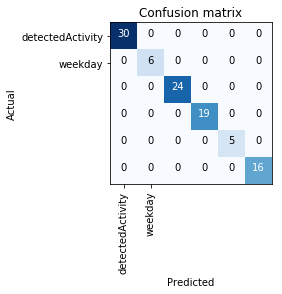

In [6]:
interp.plot_confusion_matrix()

KeyError: tensor(3)

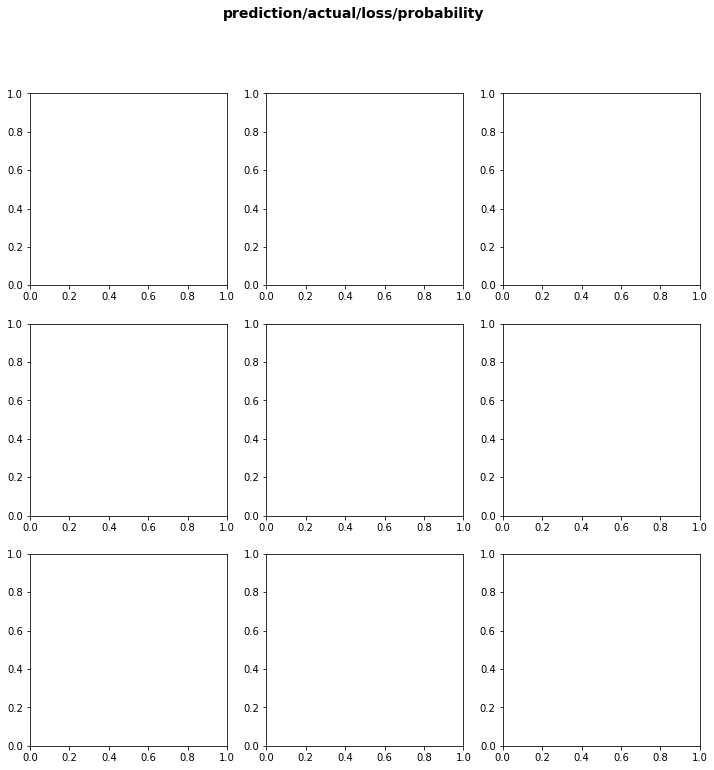

In [7]:
interp.plot_top_losses(9)